In [1]:
import sys
sys.path.insert(0, "/home/bill/pymc3/")
sys.path.insert(0, "/home/bill/packages/GPflow")

import pymc3 as pm
import GPflow

import theano
import theano.tensor as tt
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

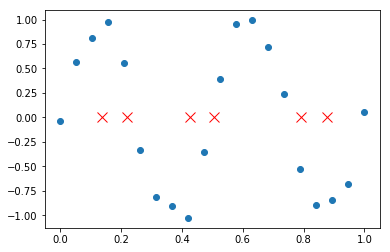

In [2]:
nx = 20
x = np.linspace(0,1,nx)
xu = np.random.rand(6)
y = np.sin(2 * np.pi * x * 2) + 0.1 * np.random.randn(nx)

plt.plot(x, y, 'o');
plt.plot(xu, 0.0*np.ones(len(xu)), 'rx', ms=10)
x = x[:,None]; xu = xu[:,None]
xs = np.linspace(-0.1, 1.1, 100)

In [3]:
def plot(xs, mu, K, title):
    fig=plt.figure(figsize=(10,4))
    ax = plt.gca()
    var = np.sqrt(np.diag(K))
    ax.plot(xu, 0.0*np.ones(len(xu)), 'rx', ms=10)
    ax.plot(xs, mu, 'k');
    ax.plot(xs, mu + 2 * var, "b");
    ax.plot(xs, mu - 2 * var, "b");
    ax.set_title(title)

full -12.026863948350261
fitc -15.158875276229425
vfe  -32.71745106770054


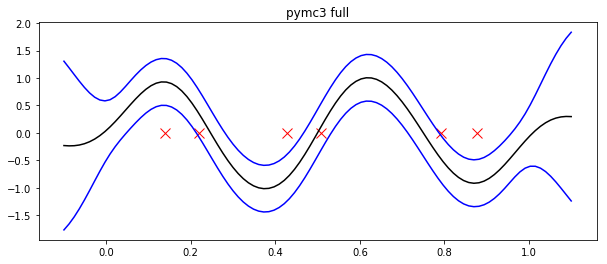

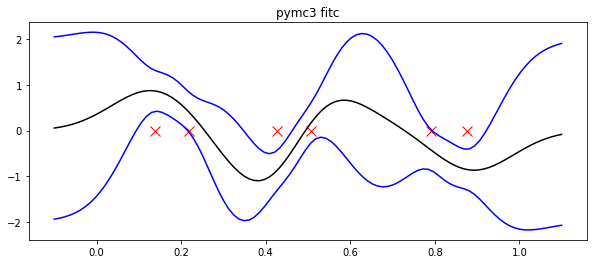

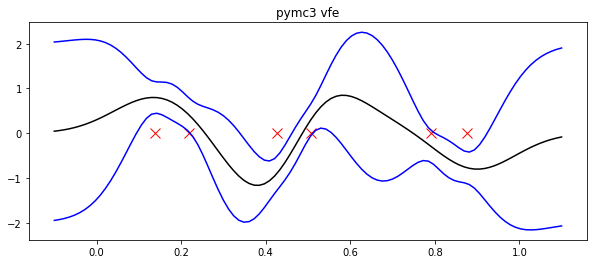

In [4]:
with pm.Model() as model1:
    #l = pm.Uniform("l", lower=0, upper=5)
    #sn2 = pm.Uniform("sn2", lower=0, upper=5)
    cov = pm.gp.cov.ExpQuad(1, 0.1)
    gp1  = pm.gp.GPFullConjugate("gp1", x, None, cov_func=cov, sigma2=0.1, observed=y)
    #start1 = pm.find_MAP(fmin=sp.optimize.fmin_l_bfgs_b)
    print("full", model1.logp())
    mean, cov = gp1.distribution.conditional(xs[:,None], y, obs_noise=False)
    mus = mean.eval().flatten()
    Kss = cov.eval()
    plot(xs, mus, Kss, "pymc3 full")
    
with pm.Model() as model2:
    #l = pm.Uniform("l", lower=0, upper=5)
    #sn2 = pm.Uniform("sn2", lower=0, upper=5)
    cov = pm.gp.cov.ExpQuad(1, 0.1)
    gp2 = pm.gp.gp.GPSparseConjugate("gp2", x, None,cov_func=cov, inducing_points=xu, 
                                     sigma2=0.1, approx="fitc", observed=y)
    #start3 = pm.find_MAP(fmin=sp.optimize.fmin_l_bfgs_b)
    print("fitc", model2.logp())   
    mean, cov = gp2.distribution.conditional(xs[:,None], y, obs_noise=False)
    mus = mean.eval().flatten()
    Kss = cov.eval()
    plot(xs, mus, Kss, "pymc3 fitc")

with pm.Model() as model3:
    #l = pm.Uniform("l", lower=0, upper=5)
    #sn2 = pm.Uniform("sn2", lower=0, upper=5)
    cov = pm.gp.cov.ExpQuad(1, 0.1)
    gp3 = pm.gp.gp.GPSparseConjugate("gp3", x, None,cov_func=cov, inducing_points=xu, 
                                     sigma2=0.1, approx="vfe", observed=y)
    #start4 = pm.find_MAP(fmin=sp.optimize.fmin_l_bfgs_b)
    print("vfe ", model3.logp())   
    mean, cov = gp3.distribution.conditional(xs[:,None], y, obs_noise=False)
    mus = mean.eval().flatten()
    Kss = cov.eval()
    plot(xs, mus, Kss, "pymc3 vfe")


full -12.0268639484
fitc -15.1588752762
vfe  -32.7174510677


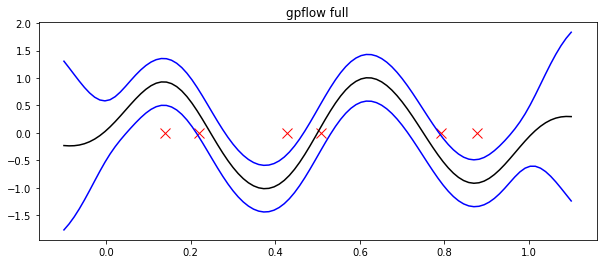

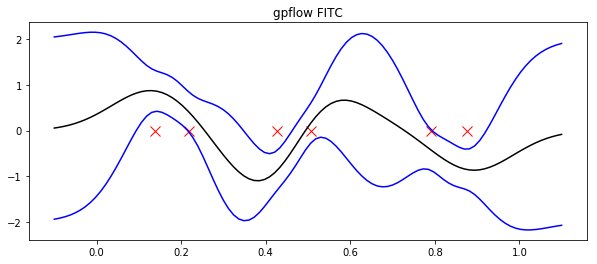

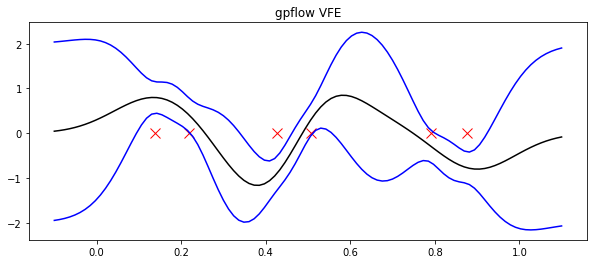

In [5]:
k = GPflow.kernels.RBF(1, lengthscales=0.1)
m = GPflow.gpr.GPR(x, y[:,None], kern=k)
m.likelihood.variance = 0.1
mus, Kss = m.predict_f_full_cov(xs[:,None])
plot(xs, mus.flatten(), Kss[:,:,0], "gpflow full")
print("full", m.compute_log_likelihood())

k = GPflow.kernels.RBF(1, lengthscales=0.1)
m = GPflow.sgpr.GPRFITC(X=x, Y=y[:,None], Z=xu, kern=k)
m.likelihood.variance = 0.1
mus, Kss = m.predict_f_full_cov(xs[:,None])
plot(xs, mus.flatten(), Kss[:,:,0], "gpflow FITC")
print("fitc", m.compute_log_likelihood())

k = GPflow.kernels.RBF(1, lengthscales=0.1)
m = GPflow.sgpr.SGPR(X=x, Y=y[:,None], Z=xu, kern=k)
m.likelihood.variance = 0.1
mus, Kss = m.predict_f_full_cov(xs[:,None])
plot(xs, mus.flatten(), Kss[:,:,0], "gpflow VFE")
print("vfe ", m.compute_log_likelihood()[0])


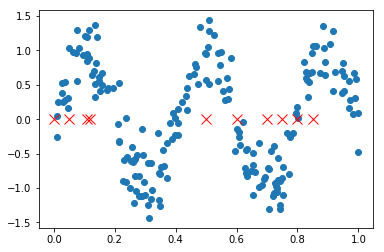

In [21]:
nx = 200
x = np.random.rand(nx)
xu = np.array([0.00, 0.05, 0.11, 0.12, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85])
y = np.sin(2 * np.pi * x * 2.5) + 0.3 * np.random.randn(nx)

plt.plot(x, y, 'o');
plt.plot(xu, 0.0*np.ones(len(xu)), 'rx', ms=10)
x = x[:,None]; xu = xu[:,None]
xs = np.linspace(-0.1, 1.1, 100)

# FITC

In [22]:
#FITC
with pm.Model() as model:
    ℓ = pm.HalfCauchy("ℓ", beta=5, testval=0.1)
    σ2_n = pm.HalfCauchy("σ2_n", beta=5, testval=0.1)
    σ2_f = pm.HalfStudentT("σ2_f", mu=1.0, lam=1.0, nu=5, testval=1.0)
    cov = pm.gp.cov.ExpQuad(1, ℓ)
    gp = pm.gp.GPSparseConjugate("gp", X=x, cov_func=cov, inducing_points=xu, 
                                 sigma2=σ2_n, approx="fitc", observed=y)
    trace = pm.fit(50000, method='advi').sample(1000, True)

Average Loss = 71.509: 100%|██████████| 50000/50000 [01:35<00:00, 524.09it/s]
Finished [100%]: Average Loss = 71.51


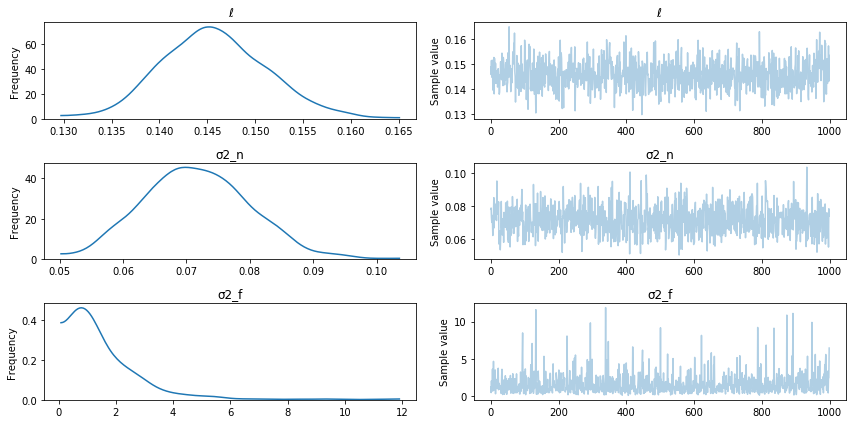

In [23]:
pm.traceplot(trace);

In [24]:
xs = np.linspace(0,1,100)[:,None]
with model:
    samples = pm.gp.sample_gp(trace[:50], gp, X_values=xs, obs_noise=False)

100%|██████████| 50/50 [00:38<00:00,  1.39it/s]


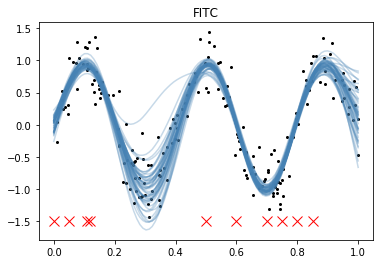

In [25]:
plt.plot(x.flatten(), y, 'ko', ms=2);
plt.plot(xu.flatten(), -1.5 * np.ones(len(xu)), "rx", ms=10)
plt.plot(xs.flatten(), samples.T, "steelblue", alpha=0.3);
plt.title("FITC")

# VFE

In [26]:
#VFE
import theano.tensor as tt
with pm.Model() as model:
    ℓ = pm.HalfCauchy("ℓ", beta=5, testval=0.1)
    σ2_n = pm.HalfCauchy("σ2_n", beta=5, testval=0.1)
    σ2_f = pm.HalfCauchy("σ2_f", beta=5, testval=1.0)
    #xu2 = pm.Uniform("xu2", lower=0, upper=1, testval=np.random.rand(7), shape=(7,))
    #xu = xu2[:,None]
    cov = pm.gp.cov.ExpQuad(1, ℓ)
    gp = pm.gp.GPSparseConjugate("gp", X=x, cov_func=cov, inducing_points=xu, 
                                 sigma2=σ2_n, approx="vfe", observed=y)
    #start = pm.find_MAP(live_disp=True)
    trace = pm.fit(50000, method='advi').sample(1000, True)
    #print(start)

Average Loss = 83.609: 100%|██████████| 50000/50000 [02:31<00:00, 330.55it/s]
Finished [100%]: Average Loss = 83.608


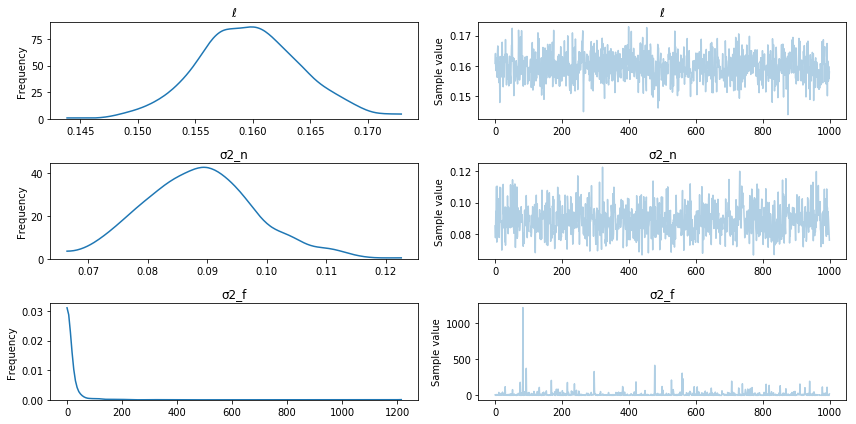

In [27]:

pm.traceplot(trace);

In [28]:
xs = np.linspace(0,1,100)[:,None]
with model:
    samples = pm.gp.sample_gp(trace[:100], gp, X_values=xs, obs_noise=False)

100%|██████████| 100/100 [01:41<00:00,  1.05s/it]


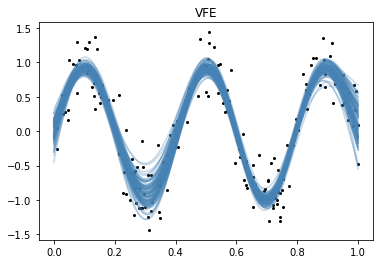

In [29]:
plt.plot(x.flatten(), y, 'ko', ms=2);
#plt.plot(xu.flatten(), -1.5 * np.ones(len(xu)), "rx", ms=10)
plt.plot(xs.flatten(), samples.T, "steelblue", alpha=0.3);
plt.title("VFE")

# FULL GP

In [15]:
#FULL
with pm.Model() as model:
    ℓ = pm.HalfCauchy("ℓ", beta=5, testval=0.1)
    σ2_n = pm.HalfCauchy("σ2_n", beta=5, testval=0.1)
    σ2_f = pm.HalfCauchy("σ2_f", beta=5, testval=1.0)
    cov = pm.gp.cov.ExpQuad(1, ℓ)
    gp = pm.gp.GPFullConjugate("gp", X=x, cov_func=cov, sigma2=σ2_n, observed=y)
    trace = pm.fit(50000, method='advi').sample(1000, True)

Average Loss = 74.901: 100%|██████████| 50000/50000 [06:05<00:00, 159.44it/s]
Finished [100%]: Average Loss = 74.9


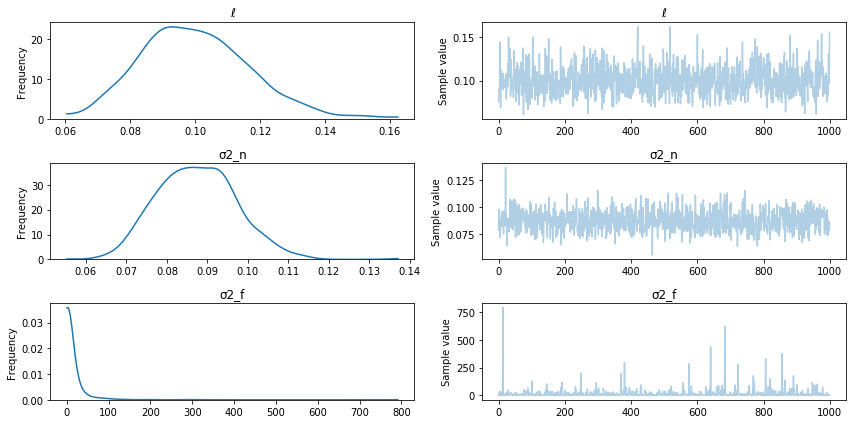

In [16]:
pm.traceplot(trace);

In [17]:
xs = np.linspace(0,1,100)[:,None]
with model:
    samples = pm.gp.sample_gp(trace[:100], gp, X_values=xs, obs_noise=False)

100%|██████████| 100/100 [00:49<00:00,  2.15it/s]


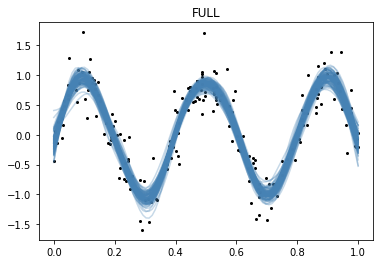

In [18]:
plt.plot(x.flatten(), y, 'ko', ms=2);
plt.plot(xs.flatten(), samples.T, "steelblue", alpha=0.3);
plt.title("FULL")

In [23]:
results = []
for n in [50, 100, 120, 140, 160, 180, 200, 250, 300, 350,400,450,500,750,1000]:
    nu = 40
    print("n =", n, "nu =", nu)
    x = np.linspace(0,1,n)[:,None]
    xu = np.linspace(0,1,nu)[:,None]
    y = np.random.randn(n)
    with pm.Model() as model:
        s2 = pm.Uniform("s2", lower=0, upper=1)
        cov = pm.gp.cov.ExpQuad(1, 0.1)
        gp = pm.gp.GPSparseConjugate("gp", cov_func=cov, X=x, inducing_points=xu, sigma2=s2, approx="fitc", observed=y)
    
    lp = model.profile(model.logpt, n=1000)
    r1 = lp.fct_call_time / lp.fct_callcount
    
    
    with pm.Model() as model:
        s2 = pm.Uniform("s2", lower=0, upper=1)
        cov = pm.gp.cov.ExpQuad(1, 0.1)
        gp = pm.gp.GPSparseConjugate("gp", cov_func=cov, X=x, inducing_points=xu, sigma2=s2, approx="vfe", observed=y)
    
    lp = model.profile(model.logpt, n=1000)
    r2 = lp.fct_call_time / lp.fct_callcount
    
    
    with pm.Model() as model:
        s2 = pm.Uniform("s2", lower=0, upper=1)
        cov = pm.gp.cov.ExpQuad(1, 0.1)
        gp = pm.gp.GPFullConjugate("gp", cov_func=cov, X=x, sigma2=s2, observed=y)
    
    lp = model.profile(model.logpt, n=1000)
    r3 = lp.fct_call_time / lp.fct_callcount
    results.append([n, r1, r2, r3])

n = 50 nu = 40
n = 100 nu = 40
n = 120 nu = 40
n = 140 nu = 40
n = 160 nu = 40
n = 180 nu = 40
n = 200 nu = 40
n = 250 nu = 40
n = 300 nu = 40
n = 350 nu = 40
n = 400 nu = 40
n = 450 nu = 40


KeyboardInterrupt: 

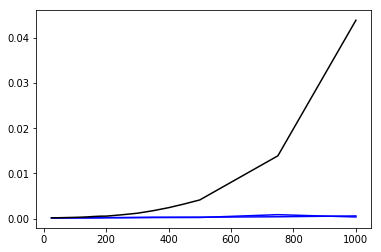

In [22]:
a = np.array(results)
plt.plot(a[:,0], a[:,1], "b");
plt.plot(a[:,0], a[:,2], "b");
plt.plot(a[:,0], a[:,3], "k");